In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [50]:
df = pd.read_csv("datos_movimiento_horizontal.csv", sep=";")
replace_commas_by_dot = lambda df, col: df[col].str.replace(",",".")
df.t = replace_commas_by_dot(df, "t")
df.x = replace_commas_by_dot(df, "x")
df = df.astype("float")
df = df.iloc[1:19, :]
df

,t,x
1,0.0333,0.0435
2,0.0667,0.0748
3,0.1000,0.1000
4,0.1330,0.1230
5,0.1670,0.1450
6,0.2000,0.1670
7,0.2330,0.1870
8,0.2670,0.2030
9,0.3000,0.2190
10,0.3330,0.2330


In [51]:
vx = [np.nan]
xs = df.x.values
ts = df.t.values

for i in range(len(df)):
    if i > 0 and i+1 < len(df):
        vel_x = (xs[i+1] - xs[i-1]) / \
                (ts[i+1] - ts[i-1] )
        vx.append(vel_x)

vx.append(np.nan)
df["vx"] = vx

df

,t,x,vx
1,0.0333,0.0435,NaN
2,0.0667,0.0748,0.847076
3,0.1000,0.1000,0.726998
4,0.1330,0.1230,0.671642
5,0.1670,0.1450,0.656716
6,0.2000,0.1670,0.636364
7,0.2330,0.1870,0.537313
8,0.2670,0.2030,0.477612
9,0.3000,0.2190,0.454545
10,0.3330,0.2330,0.462687


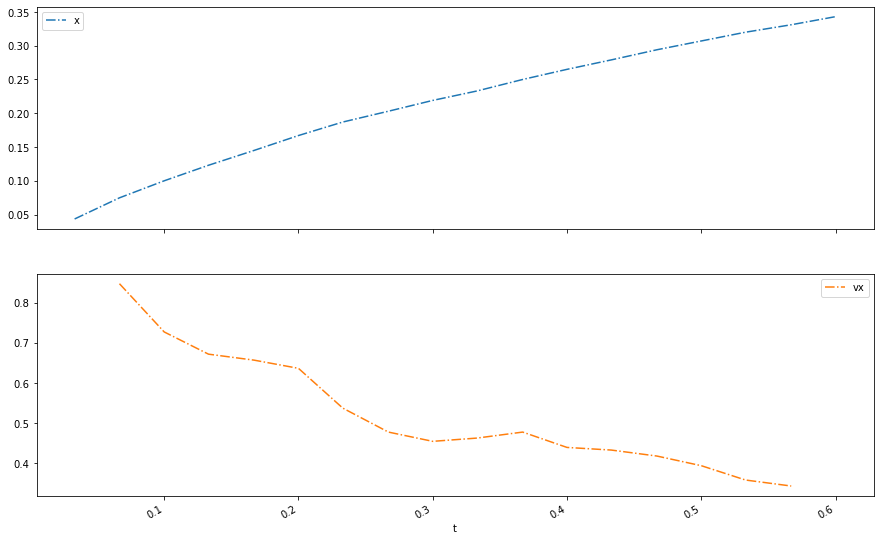

In [52]:
df.set_index("t").plot(subplots=True, figsize=(15,10), linestyle="dashdot")
plt.show()

In [53]:
df.to_csv("movimiento_horizontal_velocidad.csv", index=False)

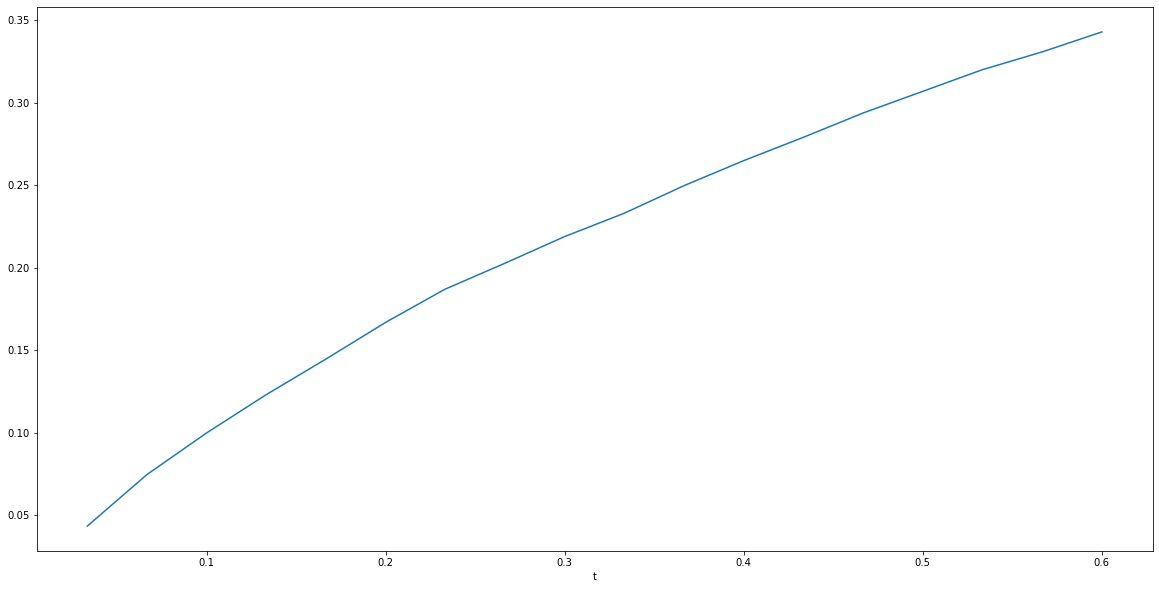

In [54]:
df.set_index("t")["x"].plot(figsize=(20,10))
plt.show()

In [55]:
time_arr = np.expand_dims(df.t.values, 1)
x_arr = np.expand_dims(df.x.values, 1)

In [56]:
lr = LinearRegression().fit(time_arr, x_arr)
print(lr.coef_)
lr.intercept_

[[0.51042346]]


array([0.05416035])

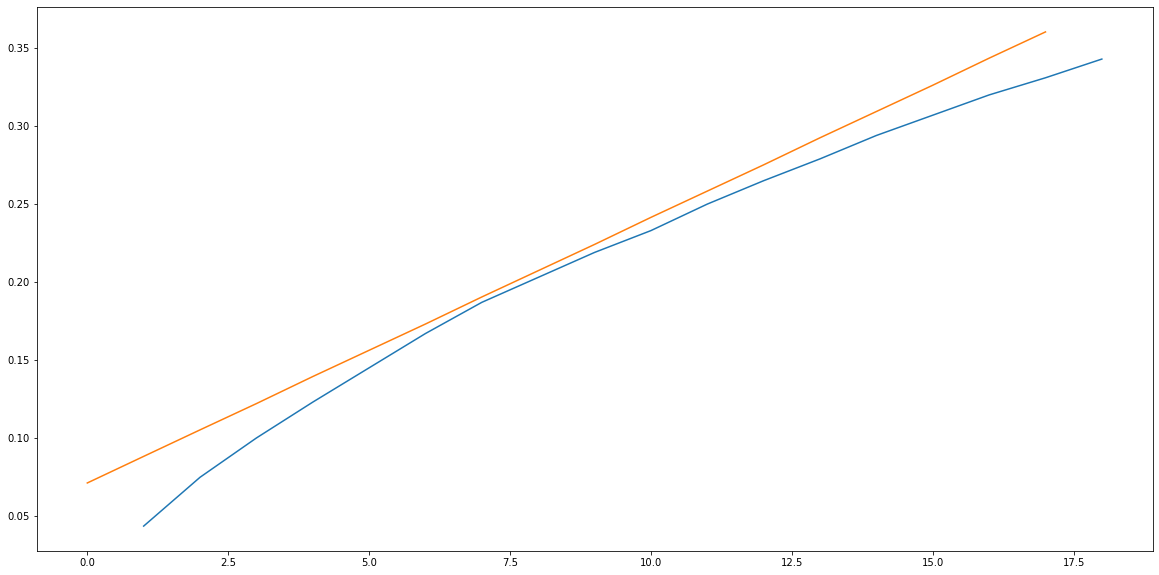

In [57]:
preds = lr.predict(time_arr)

df["x"].plot(figsize=(20,10))
plt.plot(preds)
plt.show()

In [58]:
r2_score(preds, x_arr)

0.98341924981085

## Ajustar modelos distintos para intervalos

Intervalos de 0 a 5, de 5 a 20, y de 20 en adelante

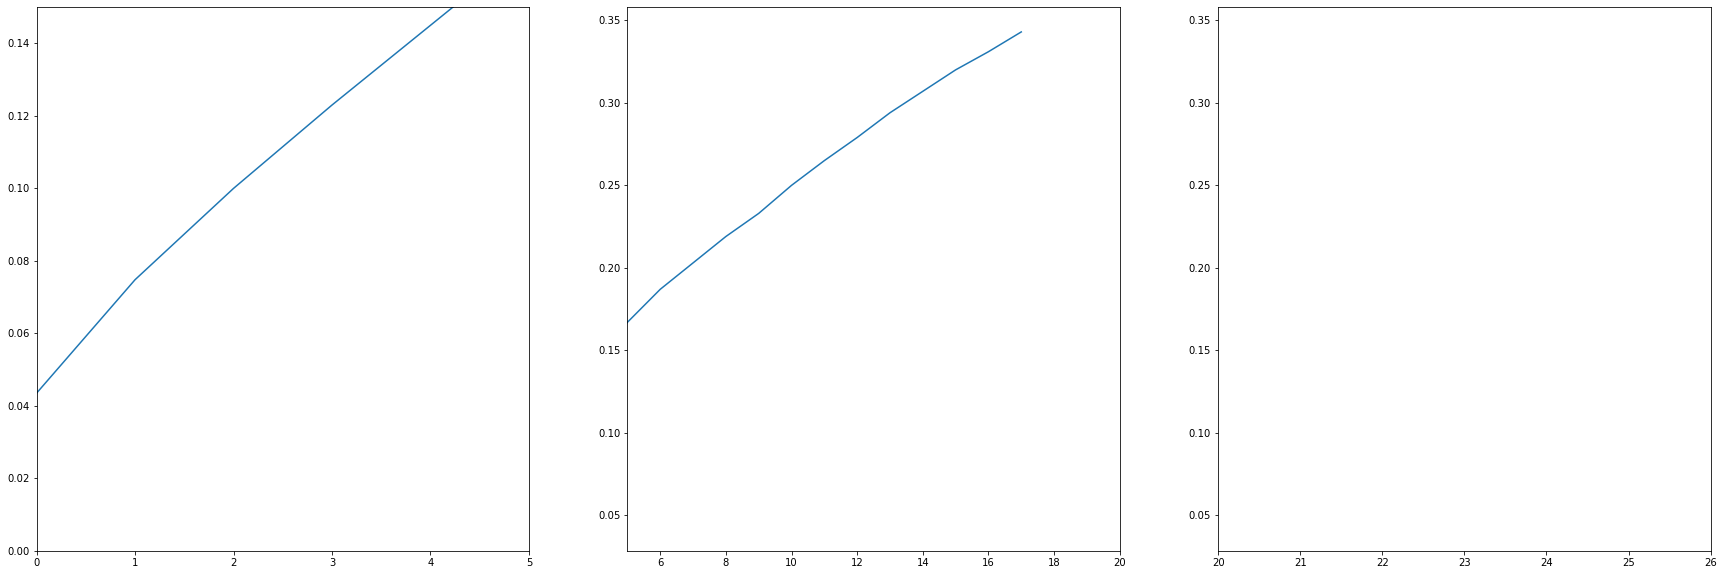

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*10,10))

ax[0].plot(df.x.values)
ax[0].set_xlim([0, 5])
ax[0].set_ylim([0, 0.15])

ax[1].plot(df.x.values)
ax[1].set_xlim([5, 20])

ax[2].plot(df.x.values)
ax[2].set_xlim([20, 26])

plt.show()

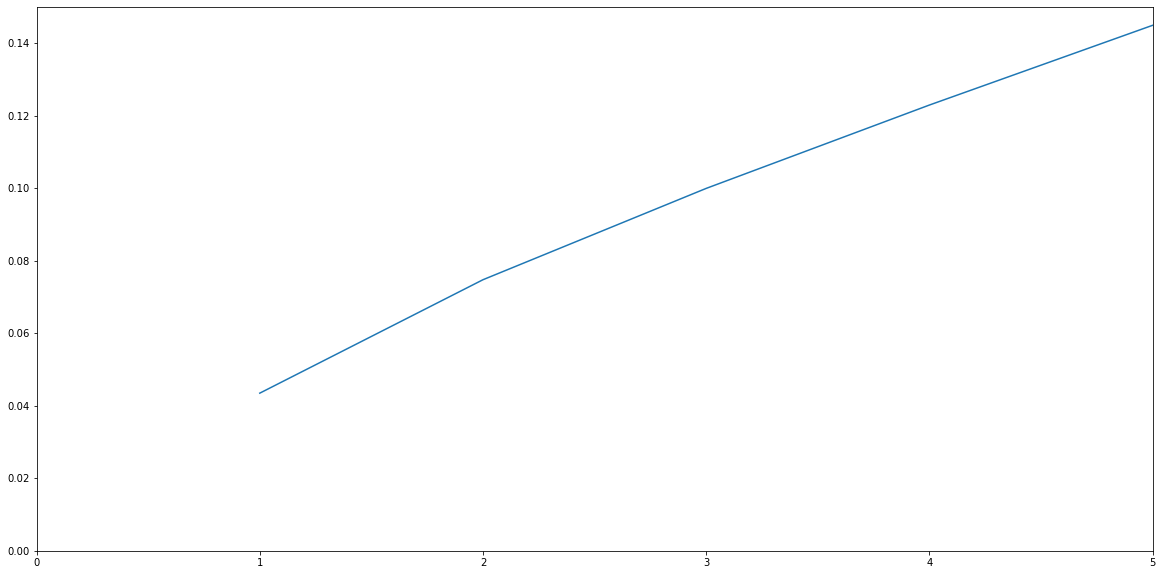

In [60]:
df["x"].plot(figsize=(20,10))
plt.xlim([0, 5])
plt.ylim([0, 0.15])
plt.show()

In [61]:
intervals = [range(0,6), range(6,21), range(20, len(df))]

for interval in intervals:
    for d in [1,2,3,4,5,6]:
        X = time_arr[interval,:]
        y = x_arr[interval, :]
        
        poly = PolynomialFeatures(degree=d)
        X_ = poly.fit_transform(X)

        clf = linear_model.LinearRegression()
        clf.fit(X_, y)
        preds = clf.predict(X_)
        r2 = r2_score(y, preds)
        print(f"Interval: {interval}, r2 = {r2}, degrees = {d}")
        #print(clf.intercept_)
        #print(clf.coef_)

Interval: range(0, 6), r2 = 0.9952340946577269, degrees = 1
Interval: range(0, 6), r2 = 0.9993488777013573, degrees = 2
Interval: range(0, 6), r2 = 0.9999781808052964, degrees = 3
Interval: range(0, 6), r2 = 0.9999879060526021, degrees = 4
Interval: range(0, 6), r2 = 1.0, degrees = 5
Interval: range(0, 6), r2 = 1.0, degrees = 6


IndexError: index 18 is out of bounds for axis 0 with size 18

In [62]:
for d in range(1, 100):
    X = time_arr
    y = x_arr

    poly = PolynomialFeatures(degree=d)
    X_ = poly.fit_transform(X)

    clf = linear_model.LinearRegression()
    clf.fit(X_, y)
    preds = clf.predict(X_)
    print(d, r2_score(y, preds))

1 0.9836896870356193
2 0.9989309304825812
3 0.9997724957065013
4 0.9998956927290252
5 0.9999005887052215
6 0.9999008877893153
7 0.9999525100720584
8 0.999967022305538
9 0.9999671175306124
10 0.9999839337709042
11 0.9999840147383212
12 0.9999866253432823
13 0.9999899486962177
14 0.999989974712188
15 0.9999927169832525
16 0.9999939376352087
17 0.9999937612640346
18 0.9999936212274555
19 0.9999935156028841
20 0.9999999750518813
21 0.9999999753784116
22 0.9999999998438943
23 0.999999999718619
24 0.999999998215937
25 0.9999999995935273
26 0.9999999986586712
27 0.999999999977509
28 0.9999999999975714
29 0.9999999999992251
30 0.9999999999974578
31 0.999999999999133
32 0.9999999999983861
33 0.9999999999896032
34 0.9999999999996175
35 0.99999999999975
36 0.9999999999993708
37 0.9999999999990992
38 0.9999999999994323
39 0.9999999999998183
40 0.999999999999869
41 0.9999999999995312
42 0.9999999999996831
43 0.9999999999989159
44 0.9999999999992321
45 0.9999999999994434
46 0.9999999999996354
47 0.9